### 🤖 Implement ReAct with LangGraph-What is ReAct?
ReAct (Reasoning + Acting) is a framework where an LLM:

- Reasons step-by-step (e.g. decomposes questions, makes decisions)

- Acts by calling tools like search, calculators, or retrievers

This makes it perfect for Agentic RAG:
✅ Think → Retrieve → Observe → Reflect → Final Answer

In [4]:
import os
from langgraph.prebuilt import create_react_agent
from langchain_classic.agents import Tool
from langchain_classic.tools import WikipediaQueryRun
from langchain_classic.utilities import WikipediaAPIWrapper
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader
from langgraph.graph import END
from langgraph.graph import StateGraph
from typing import Annotated, TypedDict, Sequence
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from langchain_text_splitters import RecursiveCharacterTextSplitter


In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

llm=init_chat_model(model_provider="groq", model="openai/gpt-oss-120b")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x11b2378c0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x11b38c440>, model_name='openai/gpt-oss-120b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [5]:
from langchain_community.embeddings import HuggingFaceEmbeddings

# --------------------------
# 1. Create Retriever Tool
# --------------------------

# Load content from blog
docs = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/").load()
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)

embedding = HuggingFaceEmbeddings()
vectorstore = FAISS.from_documents(chunks, embedding)
retriever = vectorstore.as_retriever()

/var/folders/_m/nv9cbmbs6h38d0yjvxbgmhpj_vx45m/T/ipykernel_82984/558429231.py:12: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embedding = HuggingFaceEmbeddings()
/var/folders/_m/nv9cbmbs6h38d0yjvxbgmhpj_vx45m/T/ipykernel_82984/558429231.py:12: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  embedding = HuggingFaceEmbeddings()


In [6]:
retriever.invoke("what are autonomous agents")

[Document(id='3e32833e-8c9a-48d4-932a-c1a768e13ad6', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, 

In [7]:
def retriever_tool_func(query: str) -> str:
    print("📚 Using RAGRetriever tool")
    docs = retriever.invoke(query)
    return "\n".join([doc.page_content for doc in docs])

In [8]:
retriever_tool_func("what are autonomous agents")

📚 Using RAGRetriever tool


"Citation#\nCited as:\n\nWeng, Lilian. (Jun 2023). “LLM-powered Autonomous Agents”. Lil’Log. https://lilianweng.github.io/posts/2023-06-23-agent/.\nLLM Powered Autonomous Agents | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nAgent System Overview\n\nComponent One: Planning\n\nTask Decomposition\n\nSelf-Reflection\n\n\nComponent Two: Memory\n\nTypes of Memory\n\nMaximum Inner Product Search (MIPS)\nTool use\n\nThe agent learns to call external APIs for extra information that is missing from the model weights (often hard to change after pre-training), including current information, code execution capability, access to proprietary information sources 

In [9]:
retriever_tool=Tool(
    name="RAGRetriever",
    description="Use this tool to fetch relevant knowledge base info",
    func=retriever_tool_func
)
retriever_tool
print(retriever_tool.name)

RAGRetriever


In [10]:
# Wikipedia tool
wiki_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
wiki_tool

WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from '/Users/binod.kafle/Documents/personal/learning/agentic_ai/.venv/lib/python3.14/site-packages/wikipedia/__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000))

/var/folders/_m/nv9cbmbs6h38d0yjvxbgmhpj_vx45m/T/ipykernel_82984/292727661.py:9: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  react_node=create_react_agent(llm,tools)


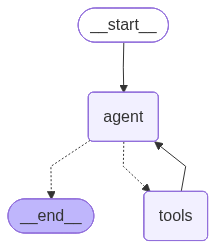

In [11]:
# ----------------------------
# 2. Define the Agent Node
# ----------------------------


tools = [retriever_tool, wiki_tool]

## create the native Langgraph react agent
react_node=create_react_agent(llm,tools)
react_node

In [12]:
# --------------------------
# 3. LangGraph Agent State
# --------------------------

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

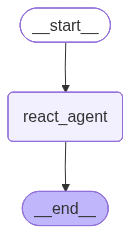

In [13]:
# --------------------------
# 4. Build LangGraph Graph
# --------------------------

builder = StateGraph(AgentState)

builder.add_node("react_agent", react_node)
builder.set_entry_point("react_agent")
builder.add_edge("react_agent", END)

graph = builder.compile()
graph

In [14]:
# --------------------------
# 5. Run the ReAct Agent
# --------------------------

if __name__ == "__main__":
    user_query = "What is an agent loop and how does Wikipedia describe autonomous agents?"
    state = {"messages": [HumanMessage(content=user_query)]}
    result = graph.invoke(state)

    print("\n✅ Final Answer:\n", result["messages"][-1].content)


✅ Final Answer:
 ### The “Agent Loop”

In the field of artificial‑intelligence and autonomous systems, an **agent loop** (sometimes called the **sense‑think‑act cycle**) is the recurring process that an agent follows in order to operate in its environment. The loop can be broken down into three core stages:

| Stage | What Happens | Typical Implementation |
|-------|--------------|------------------------|
| **Sense (Perceive)** | The agent gathers data from its surroundings through sensors, APIs, cameras, microphones, etc. | Raw sensor readings → preprocessing (filtering, normalization) |
| **Think (Decide/Plan)** | Using the perceived information, the agent updates its internal state, evaluates goals, and selects an action. This may involve reasoning, planning, learning, or optimization. | Rule‑based inference, reinforcement‑learning policy, symbolic planner, LLM prompt, etc. |
| **Act (Execute)** | The chosen action is carried out on the environment—sending commands, manipulating o

### Tool creation for RAG agents with langgraph
To create tools for RAG agents using LangGraph, you're essentially building LLM-invocable functions that your agent can call as part of its reasoning + acting loop (ReAct).

LangGraph uses the Tool abstraction from LangChain and fully supports tools for:

- RAG retrieval
- Search
- Wikipedia
- SQL
- Web APIs
- Calculators, etc.

#### ✅ Tool Design Requirements
A LangGraph tool must:

- Have a name
- Have a description (used by the LLM to decide when to use it)
- Have a callable func, accepting a single input (usually str) and returning str

In [17]:
import os
from typing import Annotated, Sequence, TypedDict
from langchain_classic.agents import Tool
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader, ArxivLoader, TextLoader
from langchain_classic.text_splitter import RecursiveCharacterTextSplitter
from langchain_classic.tools import WikipediaQueryRun
from langchain_classic.utilities import WikipediaAPIWrapper
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph, END
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph.message import add_messages
from langchain_community.document_loaders import TextLoader

In [18]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x11b2378c0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x11b38c440>, model_name='openai/gpt-oss-120b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [23]:
### Generic function to create a retireval tool
def make_retriever_tool_from_text(file,name,desc):
    docs=TextLoader(file,encoding="utf-8").load()
    chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)
    vs = FAISS.from_documents(chunks, HuggingFaceEmbeddings())
    retriever = vs.as_retriever()

    def tool_func(query:str)->str:
        print(f"📚 Using tool: {name}")
        results = retriever.invoke(query)
        return "\n\n".join(doc.page_content for doc in results)

    return Tool(name=name,description=desc,func=tool_func)

# ArXiv Tool
def arxiv_search(query: str) -> str:
    print("🧪 Searching ArXiv...")
    results = ArxivLoader(query).load()
    return "\n\n".join(doc.page_content[:1000] for doc in results[:2]) or "No papers found."

arxiv_tool = Tool(
    name="ArxivSearch",
    description="Use this tool to fetch recent academic papers on technical topics.",
    func=arxiv_search
)

# Wikipedia Tool
wiki_tool = Tool(
    name="Wikipedia",
    description="Use this tool to fetch general world knowledge from Wikipedia.",
    func=WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
)


ValidationError: 1 validation error for Tool
func
  Input should be callable [type=callable_type, input_value=WikipediaQueryRun(api_wra...content_chars_max=4000)), input_type=WikipediaQueryRun]
    For further information visit https://errors.pydantic.dev/2.12/v/callable_type

In [26]:
internal_tool_1=make_retriever_tool_from_text(
    "sample_docs.txt",
    "InternalTechDocs",
    "Search internal tech documents for proprietary architecture and methods."
)
internal_tool_1

/var/folders/_m/nv9cbmbs6h38d0yjvxbgmhpj_vx45m/T/ipykernel_82984/1764233180.py:5: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  vs = FAISS.from_documents(chunks, HuggingFaceEmbeddings())


Tool(name='InternalTechDocs', description='Search internal tech documents for proprietary architecture and methods.', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x12f6637f0>)

In [21]:
internal_tool_2 = make_retriever_tool_from_text(
    "research_notes.txt",
    "InternalResearchNotes",
    "Search internal research notes for experimental results and agent designs."
)
internal_tool_2

/var/folders/_m/nv9cbmbs6h38d0yjvxbgmhpj_vx45m/T/ipykernel_82984/3839324579.py:5: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  vs = FAISS.from_documents(chunks, HuggingFaceEmbeddings())


Tool(name='InternalResearchNotes', description='Search internal research notes for experimental results and agent designs.', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x12f2f6610>)

/var/folders/_m/nv9cbmbs6h38d0yjvxbgmhpj_vx45m/T/ipykernel_82984/2633631050.py:3: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  react_node=create_react_agent(llm,tools)


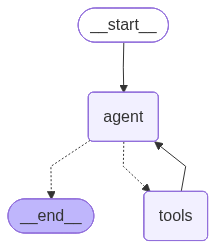

In [27]:
tools=[wiki_tool,arxiv_tool,internal_tool_1,internal_tool_2]

react_node=create_react_agent(llm,tools)
react_node

In [28]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

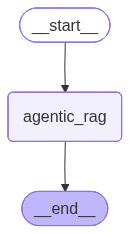

In [29]:
builder = StateGraph(AgentState)
builder.add_node("agentic_rag", react_node)
builder.set_entry_point("agentic_rag")
builder.add_edge("agentic_rag", END)

graph = builder.compile()
graph

In [31]:
query = "What do our internal research notes say about transformer variants, and what does ArXiv suggest recently?"

state = {"messages": [HumanMessage(content=query)]}
result = graph.invoke(state)

print("\n✅ Final Answer:\n", result["messages"][-1].content)

📚 Using tool: InternalResearchNotes
🧪 Searching ArXiv...
🧪 Searching ArXiv...
🧪 Searching ArXiv...
🧪 Searching ArXiv...
🧪 Searching ArXiv...
🧪 Searching ArXiv...
🧪 Searching ArXiv...


AttributeError: module 'fitz' has no attribute 'fitz'